In [3]:
import jax
import jax.numpy as jnp
import haiku as hk

from clu import metrics
from flax import linen as nn
from flax.training import train_state
from flax import struct, core
import optax

from tqdm.auto import tqdm

from matplotlib import pyplot as plt
import json
import numpy as np

from typing import Callable, Any, List

import torch, torchvision
from torchvision import transforms

from scipy.stats import ttest_ind
import seaborn as sns
import pandas as pd
import glob

import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/Users/konstantinakovlev/jax-metal/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/konstantinakovlev/jax-metal/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
def collate_fn(batch):
    return jnp.asarray(torch.stack([b[0] for b in batch], dim=0).permute(0, 2, 3, 1).cpu().numpy()), \
    jnp.array([b[1] for b in batch], dtype=jnp.int32)


transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 64

np.random.seed(0)

trainset = torch.utils.data.Subset(torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform,
                                             target_transform=lambda y: torch.randint(0, 10, (1,)).item() \
                                             if np.random.rand() < 0.5 else y), torch.arange(1000))  # attention

trainloader = {'image': jnp.asarray(torch.stack([el[0].permute(1, 2, 0) for el in trainset], dim=0).cpu().numpy()),
              'label': jnp.asarray(torch.stack([torch.tensor(el[1]) for el in trainset], dim=0).cpu().numpy()),}
trainloader['lambda'] = jnp.zeros((trainloader['image'].shape[0],), dtype=jnp.float32)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=0, collate_fn=collate_fn)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0, collate_fn=collate_fn)

# for outer optimization
valloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=0, collate_fn=collate_fn)

trainloader['image'].shape, trainloader['label'].shape, trainloader['lambda'].shape

((1000, 28, 28, 1), (1000,), (1000,))

In [6]:
class CNN(hk.Module):
    def __init__(self):
        super().__init__(name="CNN")
        self.conv1 = hk.Conv2D(output_channels=8, kernel_shape=(3,3))
        self.conv2 = hk.Conv2D(output_channels=16, kernel_shape=(3,3))
        self.conv3 = hk.Conv2D(output_channels=8, kernel_shape=(3,3))
        self.flatten = hk.Flatten()
        self.linear1 = hk.Linear(32)
        self.linear2 = hk.Linear(10)

    def __call__(self, x_batch):
        x = self.conv1(x_batch)
        x = jax.nn.relu(x)
        x = hk.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        
        x = self.conv2(x)
        x = jax.nn.relu(x)
        x = hk.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')

        x = self.conv3(x)
        x = jax.nn.relu(x)
        x = hk.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding='VALID')
        
        x = self.flatten(x)
        x = self.linear1(x)
        x = jax.nn.relu(x)
        x = self.linear2(x)
        return x

In [7]:
def ConvNet(x):
    cnn = CNN()
    return cnn(x)

conv_net = hk.transform(ConvNet)
rng = jax.random.PRNGKey(42)
params = conv_net.init(rng, jnp.ones((1, 28, 28, 1)))

print(conv_net.apply(params, None, jnp.ones((1, 28, 28, 1))).shape)

(1, 10)


In [8]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')
    

class HPOTrainState(train_state.TrainState):
    metrics: Metrics
    lr: float
    decay: float


def create_train_state(module, rng, learning_rate, momentum, decay):
    """Creates an initial `TrainState`."""
    params = module.init(rng, jnp.ones([1, 28, 28, 1]))
    opt = optax.chain(optax.add_decayed_weights(decay), optax.sgd(learning_rate, momentum))
    return HPOTrainState.create(apply_fn=module.apply,
                                         params=params,
                                         tx=opt, metrics=Metrics.empty(), lr=learning_rate, decay=decay)
    

def ConvNet(x):
    cnn = CNN()
    return cnn(x)


conv_net = hk.transform(ConvNet)
rng = jax.random.PRNGKey(42)
state = create_train_state(conv_net, jax.random.PRNGKey(0), 1e-3, 0.9, 1e-2)


In [1]:
@jax.jit
def loss_fn(params, state, batch):
    logits = state.apply_fn(params, None, batch['image'])
    loss = (optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch['label']) * jax.nn.sigmoid(batch['lambda'])).mean()
    return loss

@jax.jit
def compute_metrics(*, state, batch):
    logits = state.apply_fn(state.params, None, batch['image'])
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch['label']).mean()
    metric_updates = state.metrics.single_from_model_output(logits=logits, labels=batch['label'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state


@jax.jit
def inner_step(state: HPOTrainState, batch):    
    grad_fn = jax.grad(loss_fn, argnums=0)
    grads = grad_fn(state.params, state, batch)
    state = state.apply_gradients(grads=grads)
    return state


# @jax.jit
# def phi_update(params, batch, state):
#     grad_fn = jax.grad(loss_fn, argnums=0)
#     grads = grad_fn(params, state, batch)
#     updates, _ = state.tx.update(grads, state.opt_state, params)
#     return optax.apply_updates(params, updates)
    

@jax.jit
def B_jvp(params, batch, state, v):
    w_plus = jax.tree_util.tree_map(lambda x, y: x + 1e-7 * y, params, v)
    w_minus = jax.tree_util.tree_map(lambda x, y: x - 1e-7 * y, params, v)
    def fun(w, h):
        return loss_fn(w, state,
                       {'image': batch['image'], 'label': batch['label'], 'lambda': h})
    dl_dlam = jax.grad(fun, argnums=1)
    g_plus = dl_dlam(w_plus, batch['lambda'])
    g_minus = dl_dlam(w_minus, batch['lambda'])
    return -state.lr * (g_plus - g_minus) / (2 * 1e-7)
    

@jax.jit
def A_jvp(params, batch, state, v):
    w_plus = jax.tree_util.tree_map(lambda x, y: x + 1e-7 * y, params, v)
    w_minus = jax.tree_util.tree_map(lambda x, y: x - 1e-7 * y, params, v)
    dl_dw = jax.grad(loss_fn, argnums=0)
    g_plus = dl_dw(w_plus, state, batch)
    g_minus = dl_dw(w_minus, state, batch)
    hvp = jax.tree_util.tree_map(lambda x, y: (x - y) / (2 * 1e-7), g_plus, g_minus)
    return jax.tree_util.tree_map(lambda x, y: x - state.lr * y, v, hvp)
    
        

def proposed_so_grad(state, batches, val_batch, gamma):
    """T = len(batches)"""
    g_so_arr = []
    for step, batch in enumerate(batches):
        new_state = inner_step(state, batch)
        curr_alpha = jax.grad(loss_fn, argnums=0)(new_state.params, state, val_batch)
        g_so_arr.append(B_jvp(state.params, batch, state, curr_alpha) * gamma ** (T - 1 - step))
        state = new_state
    return state, g_so_arr
    

def drmad_grad(state, batches, val_batch):
    """T = len(batches)"""
    g_so_arr = []
    w_0 = state.params
    for step, batch in enumerate(batches):
        state = inner_step(state, batch)
    w_T = state.params
    alpha = jax.grad(loss_fn, argnums=0)(state.params, state, val_batch)
    for step, batch in enumerate(batches[::-1]):
        t = T - step
        w_tm1 = jax.tree_util.tree_map(lambda x, y: (1 - (t - 1) / T) * x + (t - 1) / T * y, w_0, w_T)
        g_so_arr.append(B_jvp(w_tm1, batch, state, alpha))
        # update alpha
        alpha = A_jvp(w_tm1, batch, state, alpha)
    return state, g_so_arr
        


def IFT_grad(state, batches, val_batch, N, K):
    """N + 1 - the number of terms from Neuman series. See (9) from i-DARTS; the number of online opt. steps"""
    g_so_arr = []
    assert len(batches) % K == 0
    for step, batch in enumerate(batches):
        state = inner_step(state, batch)
        if step >= len(batches) - K:
            v = jax.grad(loss_fn, argnums=0)(state.params, state, val_batch)
            so_grad = B_jvp(state.params, batches[-1], state, v)
            for k in range(1, N + 1):
                v = A_jvp(state.params, batches[-1], state, v)
                hvp = B_jvp(state.params, batches[-1], state, v)
                so_grad = jax.tree_util.tree_map(lambda x, y: x + y, so_grad, hvp)
            g_so_arr.append(so_grad)
            # (N + 1) * K JVPs
    return state, g_so_arr * (len(batches) // K)




NameError: name 'jax' is not defined

In [33]:
seeds = (0,1,2,3,4)#(0,1,2,3,4,5,6,7,8,9)
T = 50 #100
train_batch_size = 64
gamma = 0.99

# method = 'DrMAD'
method = 'IFT'; N = 4; K = 10
# method = 'proposed'

metrics_history = {seed: {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []} for seed in seeds}



for seed in seeds:
    print(f'Seed: {seed}')
    np.random.seed(seed)
    torch.manual_seed(seed)

    state = create_train_state(conv_net, jax.random.PRNGKey(0), 0.025, momentum=0.9, decay=1e-3)
    trainloader['lambda'] = jnp.zeros((trainloader['image'].shape[0],), dtype=jnp.float32)
    outer_opt = optax.adam(1.0)
    out_state = outer_opt.init(trainloader['lambda'])
    
    for epoch in tqdm(range(25)):
        # test
        test_state = state
        for x, y in testloader:
            test_batch = {'image': x, 'label': y}
            test_state = compute_metrics(state=test_state, batch=test_batch)
    
        for metric,value in test_state.metrics.compute().items():
            metrics_history[seed][f'test_{metric}'].append(value.item())
        
        # ATTENTION: restarts
        # state = create_train_state(conv_net, jax.random.PRNGKey(0), 1e-3)  # start from the same point
        
        x, y = next(iter(valloader))
        val_batch = {'image': x, 'label': y, 'lambda': jnp.zeros((y.shape[0],))}
        batches = []
        ids = np.random.choice(trainloader['image'].shape[0], size=(T * train_batch_size), replace=True)
        for i in range(T):
            batch = {key: trainloader[key][jnp.asarray(ids[i * train_batch_size: (i + 1) * \
                                                       train_batch_size])] for key in trainloader}
            batches.append(batch)

        if method == 'proposed':
            state, g_so_arr = proposed_so_grad(state, batches, val_batch, gamma)
        elif method == 'DrMAD':
            state, g_so_arr = drmad_grad(state, batches, val_batch)
        elif method == 'IFT':
            state, g_so_arr = IFT_grad(state, batches, val_batch, N, K)
        # outer update
        outer_grad = jnp.zeros_like(trainloader['lambda'])
        for i in range(T):
            batch_ids = ids[i * train_batch_size: (i + 1) * train_batch_size]
            # value = trainloader['lambda'][batch_ids]
            # trainloader['lambda'] = trainloader['lambda'].at[batch_ids].set(value - outer_lr * g_so_arr[i])
            outer_grad = outer_grad.at[batch_ids].set(outer_grad[batch_ids] + g_so_arr[i])
        updates, out_state = outer_opt.update(outer_grad, out_state, trainloader['lambda'])
        trainloader['lambda'] = optax.apply_updates(trainloader['lambda'], updates)
            
        for metric, value in state.metrics.compute().items(): # compute metrics
            metrics_history[seed][f'train_{metric}'].append(value.item()) # record metrics
        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch

        
    
    

Seed: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:08<00:00,  2.75s/it]


Seed: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:09<00:00,  2.77s/it]


Seed: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:09<00:00,  2.78s/it]


Seed: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:08<00:00,  2.75s/it]


Seed: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:09<00:00,  2.77s/it]


array([0.69550002, 0.71640003, 0.6821    , 0.72109997, 0.72039998])

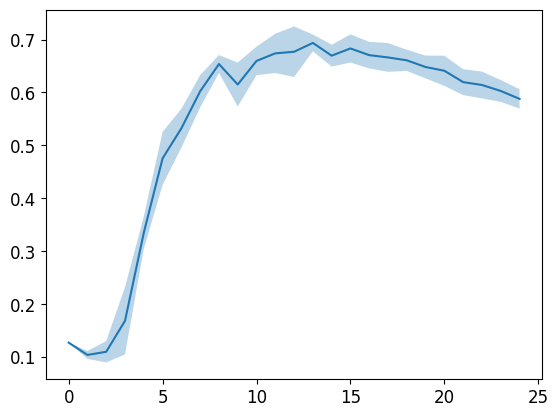

In [37]:
acc_arr = np.stack([metrics_history[s]['test_accuracy'] for s in seeds], axis=0)
plt.plot(acc_arr.mean(0))
plt.fill_between(range(acc_arr.shape[1]), acc_arr.mean(0) - acc_arr.std(0), acc_arr.mean(0) + acc_arr.std(0), alpha=0.3)

# np.save(f'results_{gamma}.npy', acc_arr)
# np.save(f'results_drmad.npy', acc_arr)
# np.save(f'results_IFT_{N}_{K}.npy', acc_arr)
acc_arr.max(-1)

Filter ratio 0.374


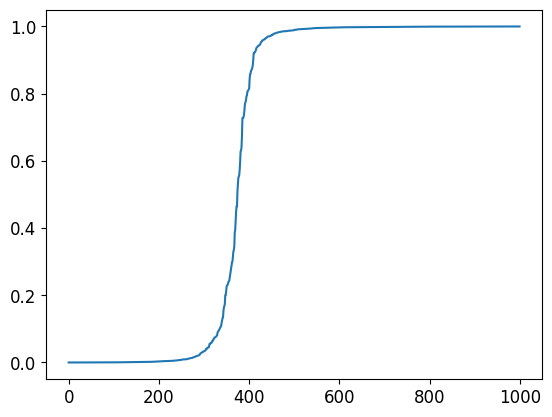

In [168]:
probs = jax.nn.sigmoid(trainloader['lambda'])
plt.plot(probs.sort().tolist())
print('Filter ratio', (probs < 0.5).mean())

In [169]:
# 1000 objects, 50% with random labeling, with restarts, 40 epochs, batch_size = 64

# gamma : {seed: accuracy}
exp_report = {
    0.01: {4: 0.6305, 1: 0.6463, 2: 0.6546, 3: 0.6312, 5: 0.6549, 6: 0.64109},
    0.9: {0: 0.6496, 1: 0.6718, 2: 0.65930, 3: 0.6557, 4: 0.6590, 5: 0.6766, 6: 0.6366, 7: 0.6629},
    0.99: {0: 0.6635, 1: 0.6721, 2: 0.65299, 3: 0.6531, 4: 0.6701, 5: 0.64969},
    0.5: {0: 0.6631, 1: 0.6567, 2: 0.6468},
    0.3: {0: 0.6583, 1: 0.6510, 2: 0.6496},
    0.8: {0: 0.66170, 1: 0.6524}
}

# 1000 objects, 50% with random labeling, w/o restarts, 60 epochs, T = 10, batch_size = 64
# gamma : {seed: accuracy}

exp_report = {
    0.01: {0: 0.7379, 1: 0.7397,},
    0.9: {0: 0.7247, 1: 0.7301},
    0.5: {0: 0.7347, 1: 0.7390999, 2: 0.7324},
    0.1: {0: 0.7404, 1: 0.7353, 2: 0.7285},
}


# 1000 objects, 50% with random labeling, w/o restarts, 30 epochs, T = 50, batch_size = 64
# gamma : {seed: accuracy}

exp_report = {
    0.01: {0: 0.7372, 1: 0.7308, 2: 0.73479, 3: 0.7368, 4: 0.723},
    0.9: {0: 0.743, 1: 0.7427, 2: 0.7333, 3: 0.7468, 4: 0.7353, 5: 0.733, 6: 0.7475, 7: 0.7441},
    0.5: {0: 0.7407, 1: 0.7422, 2: 0.727, 3: 0.74019, 4: 0.7264}
    
}



<Axes: xlabel='gamma', ylabel='acc'>

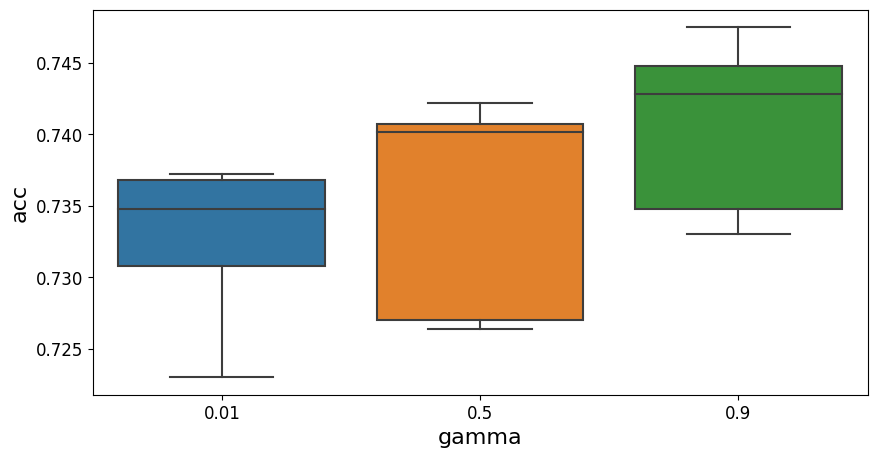

In [170]:
plt.figure(figsize=(10, 5))
data = {key: [el for el in exp_report[key].values()] for key in exp_report}
data = pd.DataFrame({'gamma': [el for key in exp_report for el in [key] * len(exp_report[key])],
                     'acc': [el for key in exp_report for el in exp_report[key].values()]})
sns.boxplot(data=data, x='gamma', y='acc')

In [171]:
gamma_1 = 0.9
gamma_2 = 0.01

data_1 = list(exp_report[gamma_1].values())
data_2 = list(exp_report[gamma_2].values())
ttest_ind(data_1, data_2), np.mean(data_1), np.mean(data_2)

(Ttest_indResult(statistic=2.4250379366522785, pvalue=0.03370473741861546),
 0.7407125,
 0.732518)

## The proposed approach outperforms truncated backprop (gamma tends to zero)

results_0.99.npy 73.5 %
results_IFT_9_5.npy 70.3 %
results_drmad.npy 69.8 %
results_0.01.npy 72.5 %
results_0.9.npy 72.8 %
results_IFT_4_10.npy 70.7 %


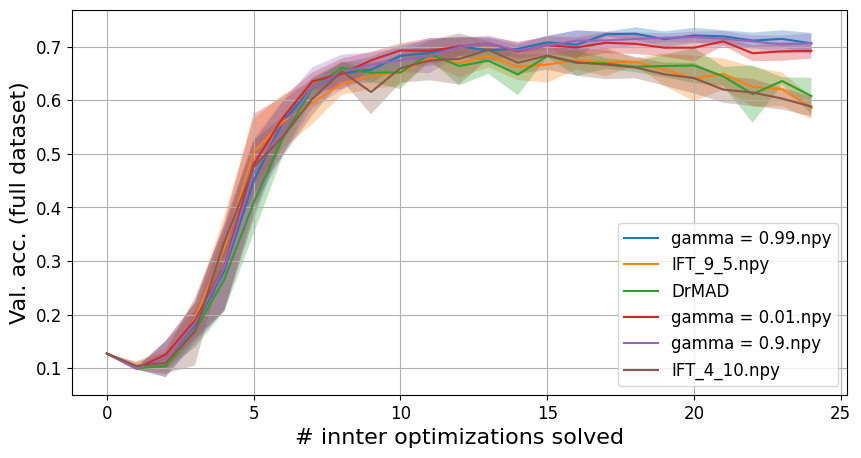

Ttest_indResult(statistic=3.3785242920902925, pvalue=0.0033469203157446468)


In [4]:
def get_label(desc_: str):
    desc = desc_.replace('results_', '')
    if 'drmad' in desc:
        return 'DrMAD'
    if 'IFT' in desc:
        return desc
    return f'gamma = {desc}'


plt.figure(figsize=(10, 5))
res = []
for file in glob.glob('*.npy'):
    m = np.load(file)
    res.append(m.max(-1))
    print(file, round(m.max(-1).mean(), 3) * 100, '%')
    label = get_label(file)
    plt.plot(m.mean(0), label=label)
    plt.fill_between(range(m.shape[1]), m.mean(0) - m.std(0), m.mean(0) + m.std(0), alpha=0.3)    
plt.xlabel('# innter optimizations solved')
plt.ylabel('Val. acc. (full dataset)')
plt.legend()
# plt.savefig('hyper_cleaning.pdf', dpi=200, bbox_inches='tight')
plt.grid()
plt.show()
print(ttest_ind(res[0], res[3]))